In [1]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt

# ベイズ線形回帰の定義
class BayesianLinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BayesianLinearRegression, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # 重みとバイアスの事前分布のパラメータ
        self.w_mu = nn.Parameter(torch.zeros(input_dim, output_dim))
        self.w_log_sigma = nn.Parameter(torch.zeros(input_dim, output_dim))
        self.b_mu = nn.Parameter(torch.zeros(output_dim))
        self.b_log_sigma = nn.Parameter(torch.zeros(output_dim))
    
    def forward(self, x):
        w_sigma = torch.exp(self.w_log_sigma)
        b_sigma = torch.exp(self.b_log_sigma)
        
        # 重みとバイアスのサンプリング
        w = self.w_mu + w_sigma * torch.randn_like(self.w_mu)
        b = self.b_mu + b_sigma * torch.randn_like(self.b_mu)
        
        return torch.matmul(x, w) + b
    
    def predict_dist(self, x):
        y = self.forward(x)
        
        # 出力の不確実性の計算
        w_sigma = torch.exp(self.w_log_sigma)
        b_sigma = torch.exp(self.b_log_sigma)
        
        # 標準偏差の計算（重みとバイアスの不確実性を考慮）
        output_sigma = torch.sqrt(torch.matmul(x**2, w_sigma**2) + b_sigma**2)
        
        return Normal(y, output_sigma)

# ベイズMLPの定義
class BayesianMLP(nn.Module):
    def __init__(self, input_dim, min_val=None, max_val=None):
        super(BayesianMLP, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 64)
        self.hidden2 = nn.Linear(64, 64)
        self.hidden3 = nn.Linear(64, 64)
        self.relu = nn.ReLU()
        self.bayesian_output = BayesianLinearRegression(64, 1)
        self.min_val = min_val
        self.max_val = max_val
    
    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        
        # ベイズ線形回帰の出力を取得
        y_dist = self.bayesian_output.predict_dist(x)

        if self.min_val or self.max_val:
            y_mean = torch.clamp(y_dist.mean, min=self.min_val, max=self.max_val)
        else:
            y_mean = y_dist.mean

        y_stddev = y_dist.stddev
        
        return Normal(y_mean, y_stddev)

# 学習ステップの定義
def train_step(model, optimizer, train_inputs, train_targets):
    optimizer.zero_grad()
    y_dist = model(train_inputs)
    loss = -y_dist.log_prob(train_targets).mean()
    loss.backward()
    optimizer.step()
    return loss.item()

# モデルのトレーニング関数の定義
def fit_pytorch_model(model, train_inputs, train_targets, num_epochs=1000, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        loss = train_step(model, optimizer, train_inputs, train_targets)
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')

Epoch 0, Loss: 7.511528968811035
Epoch 100, Loss: 4.819066047668457
Epoch 200, Loss: 2.07200288772583
Epoch 300, Loss: 3.950192451477051
Epoch 400, Loss: 2.1819770336151123
Epoch 500, Loss: 1.1696223020553589
Epoch 600, Loss: 0.989793598651886
Epoch 700, Loss: 2.3621764183044434
Epoch 800, Loss: 2.236379623413086
Epoch 900, Loss: 1.11696195602417
Epoch 1000, Loss: 1.1443428993225098
Epoch 1100, Loss: 1.2615381479263306
Epoch 1200, Loss: 1.2363982200622559
Epoch 1300, Loss: 0.9735655188560486
Epoch 1400, Loss: 0.7131742238998413
Epoch 1500, Loss: 1.4008466005325317
Epoch 1600, Loss: 1.7369792461395264
Epoch 1700, Loss: 2.5072689056396484
Epoch 1800, Loss: 0.8895658850669861
Epoch 1900, Loss: 2.3041656017303467
Epoch 2000, Loss: 0.5273070335388184
Epoch 2100, Loss: 1.0726679563522339
Epoch 2200, Loss: 3.3659369945526123
Epoch 2300, Loss: 1.5598047971725464
Epoch 2400, Loss: 2.581087112426758
Epoch 2500, Loss: 1.8160079717636108
Epoch 2600, Loss: 0.6313830018043518
Epoch 2700, Loss: 0.886

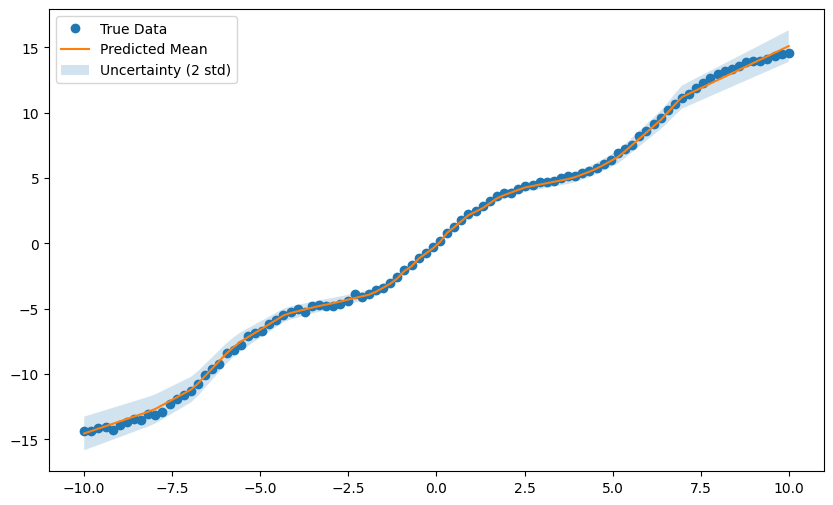

In [8]:
# データの作成
x = torch.linspace(-10, 10, 100).unsqueeze(1)
y = torch.sin(x) + 0.1 * torch.randn_like(x) + x * 1.5
# y = 0.1 * x**3 + 1 * x**2 + 2 * x + 0.1 * torch.randn_like(x)

# モデルのインスタンス化
input_dim = 1
model = BayesianMLP(input_dim)

# モデルのトレーニング
fit_pytorch_model(model, x, y, num_epochs=10000, learning_rate=0.01)

# 新しいデータに対する予測
model.eval()
x_test = torch.linspace(-10, 10, 100).unsqueeze(1)
y_test_dist = model(x_test)

y_pred_mean = y_test_dist.mean.squeeze()
y_pred_stddev = y_test_dist.stddev.squeeze()

# 予測結果のプロット
plt.figure(figsize=(10, 6))
plt.plot(x.numpy(), y.numpy(), 'o', label='True Data')
plt.plot(x_test.numpy(), y_pred_mean.detach().numpy(), label='Predicted Mean')
plt.fill_between(x_test.squeeze().numpy(), 
                 y_pred_mean.detach().numpy() - 2 * y_pred_stddev.detach().numpy(), 
                 y_pred_mean.detach().numpy() + 2 * y_pred_stddev.detach().numpy(), 
                 alpha=0.2, label='Uncertainty (2 std)')
plt.legend()
plt.show()

In [12]:
# データの作成（Sphere 関数）
x1 = torch.linspace(-10, 10, 100).unsqueeze(1)
x2 = torch.linspace(-10, 10, 100).unsqueeze(1)
X = torch.cat([x1, x2], dim=1)
y = X[:, 0]**2 + X[:, 1]**2 + 0.1 * torch.randn_like(x1)

# モデルのインスタンス化
input_dim = 2
model = BayesianMLP(input_dim)

# モデルのトレーニング
fit_pytorch_model(model, X, y, num_epochs=10000, learning_rate=0.01)

# 新しいデータに対する予測と誤差計算
model.eval()
x1_test = torch.linspace(-10, 10, 100).unsqueeze(1)
x2_test = torch.linspace(-10, 10, 100).unsqueeze(1)
X_test = torch.cat([x1_test, x2_test], dim=1)
y_test_dist = model(X_test)

y_pred_mean = y_test_dist.mean.squeeze().detach()
y_pred_stddev = y_test_dist.stddev.squeeze().detach()

# 予測誤差の計算
mae = torch.mean(torch.abs(y_pred_mean - y)).item()
mse = torch.mean((y_pred_mean - y) ** 2).item()

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

Epoch 0, Loss: 727.9625244140625
Epoch 100, Loss: 6.317432880401611
Epoch 200, Loss: 6.122922420501709
Epoch 300, Loss: 5.861454010009766
Epoch 400, Loss: 5.780088901519775
Epoch 500, Loss: 5.69130277633667
Epoch 600, Loss: 5.741458415985107
Epoch 700, Loss: 6.171117782592773
Epoch 800, Loss: 10.098516464233398
Epoch 900, Loss: 5.646113872528076
Epoch 1000, Loss: 5.707370758056641
Epoch 1100, Loss: 6.384218215942383
Epoch 1200, Loss: 9.359524726867676
Epoch 1300, Loss: 5.588623046875
Epoch 1400, Loss: 5.645357608795166
Epoch 1500, Loss: 5.61252498626709
Epoch 1600, Loss: 5.980648040771484
Epoch 1700, Loss: 5.950136661529541
Epoch 1800, Loss: 6.261835098266602
Epoch 1900, Loss: 6.5467023849487305
Epoch 2000, Loss: 5.588812351226807
Epoch 2100, Loss: 8.124520301818848
Epoch 2200, Loss: 5.834650993347168
Epoch 2300, Loss: 6.103631496429443
Epoch 2400, Loss: 5.674239158630371
Epoch 2500, Loss: 5.880756855010986
Epoch 2600, Loss: 6.015952110290527
Epoch 2700, Loss: 5.5492448806762695
Epoch 

In [16]:
# データの作成（提案された関数）
alpha = 1.0
beta = 0.5
x1 = torch.linspace(-10, 10, 100).unsqueeze(1)
x2 = torch.linspace(-10, 10, 100).unsqueeze(1)
x3 = torch.linspace(-5, 5, 100).unsqueeze(1)
X = torch.cat([x1, x2, x3], dim=1)
y = torch.exp(-alpha * (X[:, 0] - X[:, 1])**2) + beta * X[:, 2] + 0.1 * torch.randn_like(x1)

# モデルのインスタンス化
input_dim = 3
model = BayesianMLP(input_dim)

# モデルのトレーニング
fit_pytorch_model(model, X, y, num_epochs=1000, learning_rate=0.01)

# 新しいデータに対する予測と誤差計算
model.eval()
x1_test = torch.linspace(-10, 10, 100).unsqueeze(1)
x2_test = torch.linspace(-10, 10, 100).unsqueeze(1)
x3_test = torch.linspace(-5, 5, 100).unsqueeze(1)
X_test = torch.cat([x1_test, x2_test, x3_test], dim=1)
y_test_dist = model(X_test)

y_pred_mean = y_test_dist.mean.squeeze().detach()
y_pred_stddev = y_test_dist.stddev.squeeze().detach()

# 予測誤差の計算
mae = torch.mean(torch.abs(y_pred_mean - y)).item()
mse = torch.mean((y_pred_mean - y) ** 2).item()

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

Epoch 0, Loss: 2.3659398555755615
Epoch 100, Loss: 1.8233554363250732
Epoch 200, Loss: 2.017479419708252
Epoch 300, Loss: 4.609476566314697
Epoch 400, Loss: 1.8254927396774292
Epoch 500, Loss: 2.257011651992798
Epoch 600, Loss: 5.909550189971924
Epoch 700, Loss: 1.8033716678619385
Epoch 800, Loss: 1.810334324836731
Epoch 900, Loss: 1.9128015041351318
Mean Absolute Error (MAE): 1.331386685371399
Mean Squared Error (MSE): 2.4728939533233643


# 制約付き

目的関数

$
f(x_1, x_2, x_3) = e^{-\alpha (x_1 - x_2)^2} + \beta x_3
$

In [17]:
# モデルのトレーニング関数の定義
def fit_pytorch_model(model, train_inputs, train_targets, num_epochs=1000, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        loss = train_step(model, optimizer, train_inputs, train_targets)
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')

In [18]:
# データの作成（提案された関数）
alpha = 1.0
beta = 0.5
x1 = torch.linspace(-10, 10, 100).unsqueeze(1)
x2 = torch.linspace(-10, 10, 100).unsqueeze(1)
x3 = torch.linspace(-5, 5, 100).unsqueeze(1)
X = torch.cat([x1, x2, x3], dim=1)
y = torch.exp(-alpha * (X[:, 0] - X[:, 1])**2) + beta * X[:, 2] + 0.1 * torch.randn_like(x1)

# # モデルのインスタンス化
# input_dim = 3
# model = BayesianMLP(input_dim)

# # モデルのトレーニング
# fit_pytorch_model(model, X, y, num_epochs=1000, learning_rate=0.01)

# # 新しいデータに対する予測と誤差計算
# model.eval()
# x1_test = torch.linspace(-10, 10, 100).unsqueeze(1)
# x2_test = torch.linspace(-10, 10, 100).unsqueeze(1)
# x3_test = torch.linspace(-5, 5, 100).unsqueeze(1)
# X_test = torch.cat([x1_test, x2_test, x3_test], dim=1)
# y_test_dist = model(X_test)

# y_pred_mean = y_test_dist.mean.squeeze().detach()
# y_pred_stddev = y_test_dist.stddev.squeeze().detach()

# # 予測誤差の計算
# mae = torch.mean(torch.abs(y_pred_mean - y)).item()
# mse = torch.mean((y_pred_mean - y) ** 2).item()

# print(f'Mean Absolute Error (MAE): {mae}')
# print(f'Mean Squared Error (MSE): {mse}')

In [19]:
X

tensor([[-10.0000, -10.0000,  -5.0000],
        [ -9.7980,  -9.7980,  -4.8990],
        [ -9.5960,  -9.5960,  -4.7980],
        [ -9.3939,  -9.3939,  -4.6970],
        [ -9.1919,  -9.1919,  -4.5960],
        [ -8.9899,  -8.9899,  -4.4949],
        [ -8.7879,  -8.7879,  -4.3939],
        [ -8.5859,  -8.5859,  -4.2929],
        [ -8.3838,  -8.3838,  -4.1919],
        [ -8.1818,  -8.1818,  -4.0909],
        [ -7.9798,  -7.9798,  -3.9899],
        [ -7.7778,  -7.7778,  -3.8889],
        [ -7.5758,  -7.5758,  -3.7879],
        [ -7.3737,  -7.3737,  -3.6869],
        [ -7.1717,  -7.1717,  -3.5859],
        [ -6.9697,  -6.9697,  -3.4848],
        [ -6.7677,  -6.7677,  -3.3838],
        [ -6.5657,  -6.5657,  -3.2828],
        [ -6.3636,  -6.3636,  -3.1818],
        [ -6.1616,  -6.1616,  -3.0808],
        [ -5.9596,  -5.9596,  -2.9798],
        [ -5.7576,  -5.7576,  -2.8788],
        [ -5.5556,  -5.5556,  -2.7778],
        [ -5.3535,  -5.3535,  -2.6768],
        [ -5.1515,  -5.1515,  -2.5758],


In [23]:
import torch

def g(X):
    """
    check_equal_x1_x2
    """
    # x1 と x2 を取り出し、それが等しいかどうかをチェック
    result = X[:, 0] == X[:, 1]
    # 真理値ベクトルを n x 1 の形状に変換して返す
    return result.unsqueeze(1).int()


def g(X, scale=1.0):
    # x1 と x2 の差の絶対値を計算
    diff = torch.abs(X[:, 0] - X[:, 1])
    # 差の絶対値に応じて、指数関数的に 0 に近づくように変換
    result = torch.exp(-scale * diff)
    # n x 1 の形状に変換して返す
    return result.unsqueeze(1)

# サンプルデータ
n = 5
sample_tensor = torch.tensor([[1.0, 1.0, 0.5], [2.0, 3.0, 0.5], [4.0, 4.0, 0.2], [5.0, 5.0, 1.0], [7.0, 8.0, 3.0]])
print(sample_tensor)
# 関数の呼び出し
result = g(sample_tensor)
print(result)

tensor([[1.0000, 1.0000, 0.5000],
        [2.0000, 3.0000, 0.5000],
        [4.0000, 4.0000, 0.2000],
        [5.0000, 5.0000, 1.0000],
        [7.0000, 8.0000, 3.0000]])
tensor([[1.0000],
        [0.3679],
        [1.0000],
        [1.0000],
        [0.3679]])


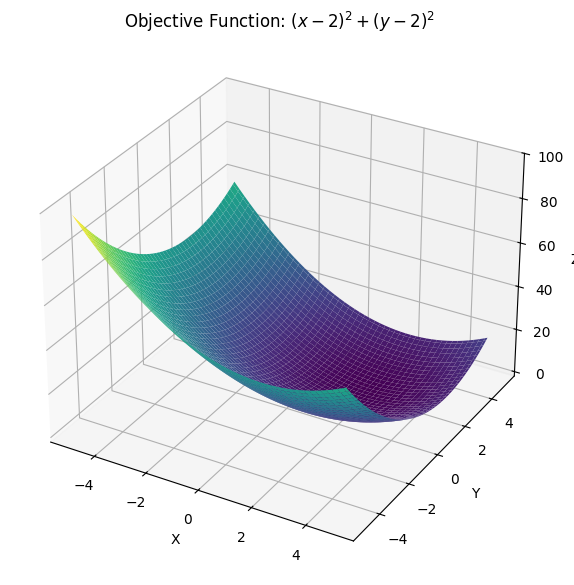

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 二変数の関数を定義
def objective_function(x, y):
    return (x - 2)**2 + (y - 2)**2

# x と y の範囲を設定
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# 関数の値を計算
Z = objective_function(X, Y)

# 3Dプロットを作成
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# ラベルの設定
ax.set_title("Objective Function: $(x-2)^2 + (y-2)^2$")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [25]:
import torch

# 符号反転する関数を定義
def negate_function(func):
    def negated_func(X):
        return -func(X)
    return negated_func

# 元の目的関数を定義
def original_objective_function(X):
    return ((X - 2) ** 2).sum(dim=-1)

# 最小化用に符号反転した目的関数
minimization_objective = negate_function(original_objective_function)

# サンプルの入力データ
X_sample = torch.tensor([[1.0, 2.0], [3.0, 4.0]])

# 元の目的関数を評価
original_result = original_objective_function(X_sample)
print(f"Original Objective Function Output: {original_result}")

# 符号反転した目的関数を評価
negated_result = minimization_objective(X_sample)
print(f"Negated Objective Function Output: {negated_result}")

Original Objective Function Output: tensor([1., 5.])
Negated Objective Function Output: tensor([-1., -5.])


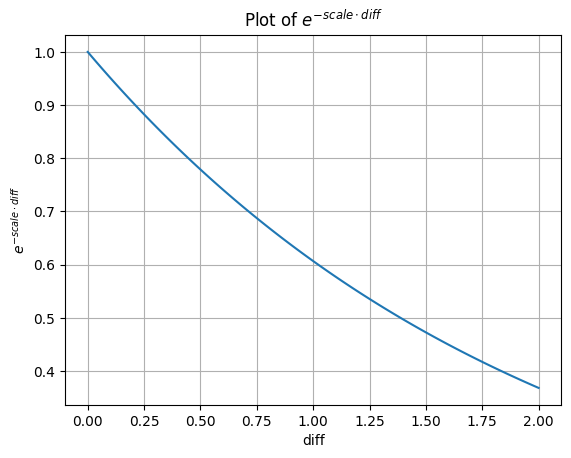

In [11]:
import torch
import matplotlib.pyplot as plt

# 定数の設定
scale = 0.5  # scaleの値を任意で設定

# diffの範囲を設定
diff = torch.linspace(0, 2, 100)  # -5から5までの100点

# 式を計算
y = torch.exp(-scale * diff)

# 結果をプロット
plt.plot(diff.numpy(), y.numpy())
plt.title(r'Plot of $e^{-scale \cdot diff}$')
plt.xlabel('diff')
plt.ylabel(r'$e^{-scale \cdot diff}$')
plt.grid(True)
plt.show()

In [26]:
temp = torch.tensor([[-4.0, -4.0, -4.0], [8.0, 8.0, 7.0]])
temp

tensor([[-4., -4., -4.],
        [ 8.,  8.,  7.]])

In [27]:
X = torch.tensor([[1.0, 1.0, 3.0], [3.0, 4.0, 5.0], [4.0, 5.0, 6.0]])

print(X)


def g(X, bounds):
    lower_bound = bounds[0]
    upper_bound = bounds[1]
    coeffs = upper_bound - lower_bound

    X1 = X[:, 0]
    X2 = X[:, 1]

    diff = torch.abs(X1 - X2).unsqueeze(1)

    return torch.ones_like(diff) - diff / coeffs.unsqueeze(-1)

g(X, temp)


tensor([[1., 1., 3.],
        [3., 4., 5.],
        [4., 5., 6.]])
tensor([12., 12., 11.])


tensor([[1.0000],
        [0.9167],
        [0.9091]])